# Aerator Imports Analysis (2021-2024)

This notebook provides an analysis of aerator imports data from customs records spanning 2021-2024. The analysis includes:

- Data loading and cleaning
- Statistical analysis and summary statistics
- Price distribution analysis
- Brand comparison
- Categorical data visualization

## Data Processing Pipeline

The analysis uses a modular approach with separate classes for data loading, cleaning, analysis, and visualization.


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Optional
from pathlib import Path

from config import (
    INPUT_DIR,
    YEAR_RANGE,
    DATE_COLUMNS,
    COLUMN_TRANSLATIONS,
    BRAND_MAPPING,
    MODEL_MAPPING,
    PRODUCT_MAPPING,
    ANALYSIS_CONFIG,
    VIZ_CONFIG,
)

print("✅ Libraries imported successfully")
print(f"📁 Input directory: {INPUT_DIR}")
print(f"📅 Year range: {YEAR_RANGE}")
print("🔧 Analysis configuration loaded")


✅ Libraries imported successfully
📁 Input directory: ../../../data/raw/aquaculture/aerator_imports/
📅 Year range: range(2021, 2025)
🔧 Analysis configuration loaded


## Data Processing Classes

Let's define our data processing classes in separate, focused cells for better organization and debugging.

### DataLoader Class

Handles loading and initial processing of aerator import data files.


In [2]:
class DataLoader:
    """Handles loading and initial processing of aerator import data files."""

    def __init__(
        self, input_dir: str = INPUT_DIR, year_range: range = YEAR_RANGE
    ):
        self.input_dir = Path(input_dir)
        self.year_range = year_range
        self.raw_data: Dict[str, pd.DataFrame] = {}

    def load_all_files(self) -> Dict[str, pd.DataFrame]:
        """Load all aerator data files for the specified year range."""
        for year in self.year_range:
            file_name = f"{year}_aerators"
            file_path = self.input_dir / f"{file_name}.csv"

            try:
                df = pd.read_csv(file_path)
                self.raw_data[file_name] = df
                print(f"✅ Loaded {file_name}: {len(df)} records")
            except FileNotFoundError:
                print(f"⚠️  File not found: {file_path}")
            except Exception as e:
                print(f"❌ Error loading {file_name}: {str(e)}")

        return self.raw_data

    def get_common_columns(self) -> List[str]:
        """Find columns present in all datasets."""
        if not self.raw_data:
            raise ValueError("No data loaded. Call load_all_files() first.")

        common_columns = set.intersection(
            *(set(df.columns) for df in self.raw_data.values())
        )
        return list(common_columns)

    def combine_datasets(self) -> pd.DataFrame:
        """Combine all datasets using only common columns."""
        common_columns = self.get_common_columns()
        print(f"🔗 Using {len(common_columns)} common columns")

        combined_data = pd.concat(
            [df[common_columns] for df in self.raw_data.values()],
            ignore_index=True,
        )
        print(f"📊 Combined dataset shape: {combined_data.shape}")
        return combined_data

    def get_data_summary(self) -> Dict[str, int]:
        """Get summary statistics for loaded data."""
        if not self.raw_data:
            return {}

        total_records = sum(len(df) for df in self.raw_data.values())
        records_by_year = {year: len(df) for year, df in self.raw_data.items()}

        return {
            "total_records": total_records,
            "records_by_year": records_by_year,
            "total_files": len(self.raw_data),
        }


print("✅ DataLoader class defined")


✅ DataLoader class defined


### DataCleaner Class

Handles data cleaning and preprocessing operations.


In [3]:
class DataCleaner:
    """Handles data cleaning and preprocessing operations."""

    def __init__(self):
        self.date_columns = DATE_COLUMNS
        self.column_translations = COLUMN_TRANSLATIONS
        self.brand_mapping = BRAND_MAPPING
        self.model_mapping = MODEL_MAPPING
        self.product_mapping = PRODUCT_MAPPING

    def convert_date_columns(self, df: pd.DataFrame) -> pd.DataFrame:
        """Convert date columns to datetime format."""
        df_cleaned = df.copy()
        conversion_results = []

        for col in self.date_columns:
            if col in df_cleaned.columns:
                orig_nulls = df_cleaned[col].isnull().sum()
                df_cleaned[col] = pd.to_datetime(
                    df_cleaned[col], errors="coerce"
                )
                new_nulls = df_cleaned[col].isnull().sum()

                conversion_results.append(
                    {
                        "column": col,
                        "orig_nulls": orig_nulls,
                        "new_nulls": new_nulls,
                        "conversion_errors": new_nulls - orig_nulls,
                    }
                )

        print(
            f"🗓️  Converted {len([c for c in self.date_columns if c in df.columns])} date columns"
        )
        return df_cleaned

    def standardize_categorical_data(self, df: pd.DataFrame) -> pd.DataFrame:
        """Standardize brand, model, and product data."""
        df_cleaned = df.copy()

        # Columns to clean (using original Spanish names)
        categorical_columns = {
            "MARCA": self.brand_mapping,
            "MODELO MERCADERIA": self.model_mapping,
            "DESCRIPCION PRODUCTO COMERCIAL": self.product_mapping,
            "MARCA COMERCIAL": self.brand_mapping,
        }

        cleaned_cols = 0
        for col, mapping in categorical_columns.items():
            if col in df_cleaned.columns:
                # Fill NaN values
                df_cleaned[col] = df_cleaned[col].fillna("GENERICO")
                # Apply mapping
                df_cleaned[col] = df_cleaned[col].replace(mapping)
                # Standardize case
                df_cleaned[col] = df_cleaned[col].astype(str).str.upper()
                cleaned_cols += 1

        print(f"🏷️  Standardized {cleaned_cols} categorical columns")
        return df_cleaned

    def clean_numeric_columns(self, df: pd.DataFrame) -> pd.DataFrame:
        """Clean and convert numeric columns, handling concatenated or invalid data."""
        df_cleaned = df.copy()

        # Define columns that should be numeric
        numeric_columns = [
            "US$ FOB UNIT",
            "CANTIDAD",
            "US$ FOB",
            "PESO NETO KG",
        ]

        cleaned_cols = 0
        for col in numeric_columns:
            if col in df_cleaned.columns:
                # Convert to string first to handle any data type issues
                df_cleaned[col] = df_cleaned[col].astype(str)

                def clean_numeric_value(value):
                    if pd.isna(value) or value in ["nan", "NaN", ""]:
                        return np.nan

                    value_str = str(value).strip()

                    # If it's too long, it's likely concatenated data
                    if len(value_str) > 20:
                        return np.nan

                    # Remove non-numeric characters but keep decimal separators
                    import re

                    cleaned = re.sub(r"[^\d.,\-]", "", value_str)

                    if not cleaned:
                        return np.nan

                    try:
                        # Handle comma as decimal separator
                        if "," in cleaned and "." not in cleaned:
                            cleaned = cleaned.replace(",", ".")
                        elif "," in cleaned and "." in cleaned:
                            cleaned = cleaned.replace(",", "")

                        return float(cleaned)
                    except (ValueError, TypeError):
                        return np.nan

                # Apply cleaning
                df_cleaned[col] = df_cleaned[col].apply(clean_numeric_value)
                # Convert to numeric
                df_cleaned[col] = pd.to_numeric(
                    df_cleaned[col], errors="coerce"
                )
                cleaned_cols += 1

        print(f"💰 Cleaned {cleaned_cols} numeric columns")
        return df_cleaned

    def clean_full_pipeline(self, df: pd.DataFrame) -> pd.DataFrame:
        """Apply the complete cleaning pipeline."""
        print("🧹 Starting data cleaning pipeline...")

        # Convert dates
        df_cleaned = self.convert_date_columns(df)

        # Standardize categorical data
        df_cleaned = self.standardize_categorical_data(df_cleaned)

        # Clean numeric columns
        df_cleaned = self.clean_numeric_columns(df_cleaned)

        print("✅ Data cleaning pipeline completed")
        return df_cleaned


print("✅ DataCleaner class defined")


✅ DataCleaner class defined


### DataAnalyzer Class

Provides data analysis and summary statistics.


In [4]:
class DataAnalyzer:
    """Provides data analysis and summary statistics."""

    def __init__(self):
        self.numeric_cols = ANALYSIS_CONFIG["numeric_cols"]
        self.categorical_cols = ANALYSIS_CONFIG["categorical_cols"]
        self.top_n = ANALYSIS_CONFIG["top_n"]

    def get_missing_values_report(self, df: pd.DataFrame) -> pd.DataFrame:
        """Generate a comprehensive missing values report."""
        missing_values = df.isnull().sum()
        missing_values = missing_values[missing_values > 0].sort_values(
            ascending=False
        )

        missing_percent = (missing_values / len(df) * 100).round(2)

        report = pd.DataFrame(
            {
                "Missing Values": missing_values,
                "Percentage (%)": missing_percent,
            }
        )

        return report

    def get_summary_statistics(self, df: pd.DataFrame) -> Dict[str, float]:
        """Calculate summary statistics for the dataset."""
        numeric_df = df.select_dtypes(include=[np.number])

        stats = {
            "total_rows": len(df),
            "total_columns": len(df.columns),
            "missing_cells": df.isnull().sum().sum(),
            "missing_percentage": (df.isnull().sum().sum() / df.size) * 100,
            "memory_usage_mb": df.memory_usage(deep=True).sum() / (1024**2),
            "numeric_columns": len(numeric_df.columns),
            "categorical_columns": len(df.columns) - len(numeric_df.columns),
        }

        return stats

    def get_top_categories(
        self, df: pd.DataFrame, column: str, n: int = None
    ) -> pd.DataFrame:
        """Get top N categories for a given column."""
        if n is None:
            n = self.top_n

        if column not in df.columns:
            raise ValueError(f"Column '{column}' not found in dataframe")

        top_categories = df[column].value_counts().head(n)

        result = pd.DataFrame(
            {
                column.title(): top_categories.index,
                "Count": top_categories.values,
                "Percentage (%)": (
                    top_categories.values / len(df) * 100
                ).round(2),
            }
        )

        return result

    def analyze_price_distribution(
        self, df: pd.DataFrame, price_col: str = "US$ FOB UNIT"
    ) -> Dict[str, float]:
        """Analyze price distribution statistics."""
        if price_col not in df.columns:
            raise ValueError(f"Price column '{price_col}' not found")

        prices = df[price_col].dropna()

        stats = {
            "count": len(prices),
            "mean": prices.mean(),
            "median": prices.median(),
            "std": prices.std(),
            "min": prices.min(),
            "max": prices.max(),
            "q25": prices.quantile(0.25),
            "q75": prices.quantile(0.75),
            "q95": prices.quantile(0.95),
        }

        return stats


print("✅ DataAnalyzer class defined")


✅ DataAnalyzer class defined


### Visualizer Class

Handles all visualization and plotting operations - broken into focused methods for better control.


In [5]:
class Visualizer:
    """Handles all visualization and plotting operations."""

    def __init__(self):
        self.config = VIZ_CONFIG
        self.numeric_cols = ANALYSIS_CONFIG["numeric_cols"]
        self.categorical_cols = ANALYSIS_CONFIG["categorical_cols"]

        # Set default style
        sns.set_style(self.config["style"])
        plt.rcParams["figure.dpi"] = self.config["dpi"]

    def _setup_plot_style(self, fig: plt.Figure, ax: plt.Axes) -> None:
        """Apply consistent styling to plots."""
        fig.patch.set_facecolor(self.config["background_color"])
        ax.set_facecolor(self.config["background_color"])
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_color(self.config["background_color"])
        ax.spines["bottom"].set_color(self.config["background_color"])

    def _format_large_number(self, value: float) -> str:
        """Format large numbers with appropriate suffixes for display."""
        if value > 1000000:
            return f"{value / 1000000:.1f}M"
        elif value > 1000:
            return f"{value / 1000:.0f}K"
        else:
            return f"{value:,.0f}"

    def _format_value(self, value: float) -> str:
        """Format large numbers with appropriate suffixes."""
        if value > 1000000:
            return f"{value / 1000000:.1f}M"
        elif value > 1000:
            return f"{value / 1000:.0f}K"
        else:
            return f"{value:,.0f}"


print("✅ Visualizer class base defined")


✅ Visualizer class base defined


In [6]:
# Add summary statistics visualization method to Visualizer class
def create_summary_stats_visualization(
    self, summary_stats: Dict[str, float], figsize: Tuple[int, int] = (14, 10)
) -> plt.Figure:
    """Create a comprehensive visualization of summary statistics."""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(
        2, 2, figsize=figsize, gridspec_kw={"hspace": 0.4, "wspace": 0.4}
    )

    # Apply consistent styling
    for ax in [ax1, ax2, ax3, ax4]:
        self._setup_plot_style(fig, ax)

    # 1. Dataset Overview (top-left)
    overview_data = [
        summary_stats["total_rows"],
        summary_stats["total_columns"],
        summary_stats["numeric_columns"],
        summary_stats["categorical_columns"],
    ]
    overview_labels = [
        "Total\nRows",
        "Total\nColumns",
        "Numeric\nColumns",
        "Categorical\nColumns",
    ]
    colors1 = sns.color_palette(self.config["color_palette"], n_colors=4)

    bars1 = ax1.bar(
        overview_labels,
        overview_data,
        color=colors1,
        alpha=0.7,
        edgecolor="black",
    )
    ax1.set_title("Dataset Overview", fontsize=14, fontweight="bold", pad=20)
    ax1.set_ylabel("Count", fontsize=12)

    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax1.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + max(overview_data) * 0.01,
            f"{int(height):,}",
            ha="center",
            va="bottom",
            fontweight="bold",
        )

    # 2. Data Quality Metrics (top-right)
    quality_data = [
        summary_stats["missing_percentage"],
        100 - summary_stats["missing_percentage"],
    ]
    quality_labels = ["Missing Data %", "Complete Data %"]
    colors2 = ["#FF6B6B", "#4ECDC4"]

    wedges, texts, autotexts = ax2.pie(
        quality_data,
        labels=quality_labels,
        colors=colors2,
        autopct="%1.1f%%",
        startangle=90,
        explode=(0.05, 0),
        textprops={"fontsize": 10},
    )
    ax2.set_title("Data Completeness", fontsize=14, fontweight="bold", pad=15)

    # Style the pie chart text
    for autotext in autotexts:
        autotext.set_color("white")
        autotext.set_fontweight("bold")
        autotext.set_fontsize(11)

    # 3. Memory Usage (bottom-left)
    memory_mb = summary_stats["memory_usage_mb"]
    memory_data = [memory_mb]
    memory_labels = [f"Memory Usage\n({memory_mb:.2f} MB)"]

    bars3 = ax3.barh(
        memory_labels,
        memory_data,
        color="#95A5A6",
        alpha=0.8,
        edgecolor="black",
    )
    ax3.set_title("Memory Footprint", fontsize=14, fontweight="bold", pad=20)
    ax3.set_xlabel("Memory (MB)", fontsize=12)

    # 4. Data Volume Breakdown (bottom-right)
    total_cells = summary_stats["total_rows"] * summary_stats["total_columns"]
    missing_cells = summary_stats["missing_cells"]
    data_cells = total_cells - missing_cells

    volume_data = [data_cells, missing_cells]
    volume_labels = ["Data Cells", "Missing Cells"]
    colors4 = ["#3498DB", "#E74C3C"]

    bars4 = ax4.bar(
        volume_labels, volume_data, color=colors4, alpha=0.7, edgecolor="black"
    )
    ax4.set_title(
        "Data Volume Breakdown", fontsize=14, fontweight="bold", pad=20
    )
    ax4.set_ylabel("Number of Cells", fontsize=12)

    # Add value labels with smart formatting
    for bar in bars4:
        height = bar.get_height()
        formatted_height = self._format_large_number(height)
        ax4.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + max(volume_data) * 0.01,
            formatted_height,
            ha="center",
            va="bottom",
            fontweight="bold",
        )

    plt.subplots_adjust(top=0.90, bottom=0.1, left=0.1, right=0.95)
    plt.show()
    return fig


# Bind method to Visualizer class
Visualizer.create_summary_stats_visualization = (
    create_summary_stats_visualization
)
print("✅ Summary stats visualization method added")


✅ Summary stats visualization method added


In [42]:
# Add price distribution visualization method to Visualizer class
def create_price_distribution_plot(
    self, df: pd.DataFrame, price_col: str = "US$ FOB UNIT"
) -> plt.Figure:
    """Create price distribution analysis plot."""
    prices = df[price_col].dropna()

    # Calculate statistics
    mean_price = prices.mean()
    percentile_95 = prices.quantile(0.95)

    # Create figure for price distribution
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    # Price distribution plot
    sns.kdeplot(
        data=prices,
        fill=True,
        color="steelblue",
        alpha=0.7,
        linewidth=2,
        clip=(0, percentile_95),
        bw_adjust=0.5,
        ax=ax,
    )

    # Add mean line
    ax.axvline(
        mean_price,
        color="crimson",
        linestyle="--",
        linewidth=2,
        label=f"Mean: ${mean_price:.2f}",
    )

    self._setup_plot_style(fig, ax)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(True)
    ax.spines["left"].set_color("black")
    ax.spines["bottom"].set_visible(True)
    ax.spines["bottom"].set_color("black")

    ax.set_xlabel("Purchase Price (USD)", fontsize=20, fontweight="bold", loc="right")
    ax.set_xlim(300, percentile_95 * 1.05)  # Extend x-axis slightly beyond 95th percentile
    ax.tick_params(axis="x", rotation=0, labelsize=20)
    ax.tick_params(axis="y", labelsize=20)
    ax.set_ylabel("Density", fontsize=20, fontweight="bold", loc="top", rotation=0)
    ax.set_title(
        "Price Distribution", fontsize=24, fontweight="bold", pad=20
    )
    ax.legend(loc="upper right", bbox_to_anchor=(0.95, 0.95), fontsize=22)
    ax.grid(axis="x", alpha=0.3, linestyle="--")

    plt.tight_layout()
    plt.show()
    return fig


# Bind method to Visualizer class
Visualizer.create_price_distribution_plot = create_price_distribution_plot
print("✅ Price distribution visualization method added")


✅ Price distribution visualization method added


In [62]:
# Add brand price comparison visualization method to Visualizer class
def create_brand_price_comparison_plot(
    self, df: pd.DataFrame, price_col: str = "US$ FOB UNIT"
) -> plt.Figure:
    """Create brand price comparison plot."""
    # Filter brands for price analysis
    price_range = ANALYSIS_CONFIG["price_filter_range"]
    brand_avg_prices = df.groupby("MARCA")[price_col].mean()
    filtered_brands = brand_avg_prices[
        (brand_avg_prices >= price_range[0])
        & (brand_avg_prices <= price_range[1])
    ].nlargest(10)

    # Create figure for brand comparison
    fig, ax = plt.subplots(1, 1, figsize=(14, 10))

    # Create vertical bar plot
    colors = sns.color_palette(
        self.config["color_palette"], len(filtered_brands)
    )

    bars = ax.bar(
        x=range(len(filtered_brands)),
        height=filtered_brands.values,
        color=colors,
        alpha=0.7,
        edgecolor="black",
        linewidth=1,
    )

    # Add value labels on top of bars
    for i, (bar, value) in enumerate(zip(bars, filtered_brands.values)):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            value + max(filtered_brands) * 0.01,
            f"${value:.0f}",
            ha="center",
            va="bottom",
            fontsize=20,
            fontweight="bold",
        )

    self._setup_plot_style(fig, ax)

    # Customize axes
    ax.set_xticks(range(len(filtered_brands)))
    ax.set_yticklabels([])
    ax.set_xticklabels([])  # Hide x-axis labels to use legend instead
    ax.set_ylabel("", fontsize=12, fontweight="bold", loc="top", rotation=0)
    ax.set_title(
        "Average Unit Price by Brand - Aerator Imports (2021-2024)",
        fontsize=20,
        fontweight="bold",
        pad=20,
    )
    ax.grid(axis="y", alpha=0.3, linestyle="--")

    # Set y-axis to start from 0 for better comparison
    ax.set_ylim(0, max(filtered_brands.values) * 1.1)

    # Create legend with brand names
    legend_elements = []
    for i, (brand_name, price) in enumerate(filtered_brands.items()):
        display_name = str(brand_name)
        if len(display_name) > 20:
            display_name = display_name[:17] + "..."
        legend_elements.append(
            plt.Rectangle(
                (0, 0),
                1,
                1,
                fc=colors[i],
                alpha=0.7,
                edgecolor="black",
                label=f"{i + 1}. {display_name}",
            )
        )

    legend = ax.legend(
        handles=legend_elements,
        loc="center left",
        bbox_to_anchor=(1.02, 0.8),
        ncol=1,
        fontsize=20,
        frameon=False,
        title="",
        title_fontsize=12,
    )

    legend.get_title().set_fontweight("bold")
    plt.tight_layout()
    plt.show()
    return fig


# Bind method to Visualizer class
Visualizer.create_brand_price_comparison_plot = (
    create_brand_price_comparison_plot
)
print("✅ Brand price comparison visualization method added")


✅ Brand price comparison visualization method added


### AeratorDataProcessor Class

Main orchestrator class that coordinates all components in a modular way.


In [9]:
class AeratorDataProcessor:
    """Main orchestrator class that coordinates all components."""

    def __init__(self, input_dir: str = INPUT_DIR):
        self.input_dir = input_dir
        self.loader = DataLoader(input_dir)
        self.cleaner = DataCleaner()
        self.analyzer = DataAnalyzer()
        self.visualizer = Visualizer()

        self.raw_data: Optional[Dict[str, pd.DataFrame]] = None
        self.combined_data: Optional[pd.DataFrame] = None
        self.cleaned_data: Optional[pd.DataFrame] = None

    def load_data(self) -> Dict[str, pd.DataFrame]:
        """Load all data files."""
        print("📁 Loading aerator import data files...")
        self.raw_data = self.loader.load_all_files()
        print(f"✅ Loaded {len(self.raw_data)} data files")
        return self.raw_data

    def process_data(self, drop_missing: bool = True) -> pd.DataFrame:
        """Complete data processing pipeline."""
        if self.raw_data is None:
            self.load_data()

        print("🔗 Combining datasets...")
        # Combine datasets
        self.combined_data = self.loader.combine_datasets()

        print("🧹 Cleaning data...")
        # Clean data
        self.cleaned_data = self.cleaner.clean_full_pipeline(
            self.combined_data
        )

        # Optionally drop rows with missing values
        if drop_missing:
            original_rows = len(self.cleaned_data)
            self.cleaned_data = self.cleaned_data.dropna()
            dropped_rows = original_rows - len(self.cleaned_data)
            if dropped_rows > 0:
                print(f"⚠️  Dropped {dropped_rows} rows with missing values")

        print(
            f"✅ Data processing complete. Final shape: {self.cleaned_data.shape}"
        )
        return self.cleaned_data

    def analyze_data(self) -> Dict[str, any]:
        """Perform comprehensive data analysis."""
        if self.cleaned_data is None:
            raise ValueError(
                "No cleaned data available. Run process_data() first."
            )

        print("📊 Performing data analysis...")
        results = {
            "summary_stats": self.analyzer.get_summary_statistics(
                self.cleaned_data
            ),
            "missing_values": self.analyzer.get_missing_values_report(
                self.cleaned_data
            ),
            "top_brands": self.analyzer.get_top_categories(
                self.cleaned_data, "MARCA"
            ),
            "top_models": self.analyzer.get_top_categories(
                self.cleaned_data, "MODELO MERCADERIA"
            ),
            "top_countries": self.analyzer.get_top_categories(
                self.cleaned_data, "PAIS DE PROCEDENCIA"
            ),
            "price_stats": self.analyzer.analyze_price_distribution(
                self.cleaned_data
            ),
        }
        print("✅ Data analysis complete")
        return results

    def create_visualizations(
        self, analysis_results: Dict[str, any]
    ) -> Dict[str, any]:
        """Create all visualizations."""
        if self.cleaned_data is None:
            raise ValueError(
                "No cleaned data available. Run process_data() first."
            )

        print("🎨 Creating visualizations...")
        visualizations = {
            "summary_stats": [
                self.visualizer.create_summary_stats_visualization(
                    analysis_results["summary_stats"]
                )
            ],
            "categorical_plots": self.visualizer.create_categorical_analysis_plots(
                self.cleaned_data
            ),
            "price_distribution": [
                self.visualizer.create_price_distribution_plot(
                    self.cleaned_data
                )
            ],
            "brand_price_comparison": [
                self.visualizer.create_brand_price_comparison_plot(
                    self.cleaned_data
                )
            ],
        }
        print("✅ Visualizations created")
        return visualizations

    def run_full_analysis(
        self,
    ) -> Tuple[pd.DataFrame, Dict[str, any], Dict[str, any]]:
        """Run the complete analysis pipeline."""
        # Load and process data
        cleaned_data = self.process_data()
        analysis_results = self.analyze_data()
        visualizations = self.create_visualizations(analysis_results)
        return cleaned_data, analysis_results, visualizations
        # Analyze data


print("✅ AeratorDataProcessor class defined")


✅ AeratorDataProcessor class defined


### AeratorDataProcessor Class

Main orchestrator class that coordinates all components in a modular way.


In [10]:
# Step 1: Initialize the data processor
processor = AeratorDataProcessor()
print("🚀 AeratorDataProcessor initialized")
print(
    "🔧 Components loaded: DataLoader, DataCleaner, DataAnalyzer, Visualizer"
)


🚀 AeratorDataProcessor initialized
🔧 Components loaded: DataLoader, DataCleaner, DataAnalyzer, Visualizer


### Step 2: Load Raw Data

Load all aerator import data files from 2021-2024.


In [11]:
# Step 2: Load raw data files
raw_data = processor.load_data()
print(f"📊 Loaded data files: {list(raw_data.keys())}")
for file_name, df in raw_data.items():
    print(f"   {file_name}: {df.shape[0]:,} records, {df.shape[1]} columns")


📁 Loading aerator import data files...
✅ Loaded 2021_aerators: 463 records
✅ Loaded 2022_aerators: 571 records
✅ Loaded 2023_aerators: 365 records
✅ Loaded 2024_aerators: 365 records
✅ Loaded 4 data files
📊 Loaded data files: ['2021_aerators', '2022_aerators', '2023_aerators', '2024_aerators']
   2021_aerators: 463 records, 58 columns
   2022_aerators: 571 records, 60 columns
   2023_aerators: 365 records, 60 columns
   2024_aerators: 365 records, 60 columns


### Step 3: Process and Clean Data

Combine datasets and apply data cleaning pipeline.


In [12]:
# Step 3: Process and clean the data
cleaned_data = processor.process_data(drop_missing=True)
print("✅ Data processing complete!")
print(f"📈 Final cleaned dataset shape: {cleaned_data.shape}")
print(
    f"📊 Memory usage: {cleaned_data.memory_usage(deep=True).sum() / 1024**2:.2f} MB"
)


🔗 Combining datasets...
🔗 Using 54 common columns
📊 Combined dataset shape: (1764, 54)
🧹 Cleaning data...
🧹 Starting data cleaning pipeline...
🗓️  Converted 5 date columns
🏷️  Standardized 4 categorical columns
💰 Cleaned 4 numeric columns
✅ Data cleaning pipeline completed
⚠️  Dropped 1061 rows with missing values
✅ Data processing complete. Final shape: (703, 54)
✅ Data processing complete!
📈 Final cleaned dataset shape: (703, 54)
📊 Memory usage: 1.48 MB


### Step 4: Perform Data Analysis

Generate comprehensive statistics and analysis results.


In [13]:
# Step 4: Perform comprehensive data analysis
analysis_results = processor.analyze_data()
print("🔍 Analysis results generated:")
print(
    f"   - Summary statistics: {len(analysis_results['summary_stats'])} metrics"
)
print(
    f"   - Missing values report: {len(analysis_results['missing_values'])} entries"
)
print(f"   - Top brands: {len(analysis_results['top_brands'])} entries")
print(f"   - Top models: {len(analysis_results['top_models'])} entries")
print(f"   - Top countries: {len(analysis_results['top_countries'])} entries")
print(f"   - Price statistics: {len(analysis_results['price_stats'])} metrics")


📊 Performing data analysis...
✅ Data analysis complete
🔍 Analysis results generated:
   - Summary statistics: 7 metrics
   - Missing values report: 0 entries
   - Top brands: 10 entries
   - Top models: 10 entries
   - Top countries: 10 entries
   - Price statistics: 9 metrics


### Create Summary Statistics Visualization

Generate the summary statistics dashboard to avoid plotting all graphs at once.


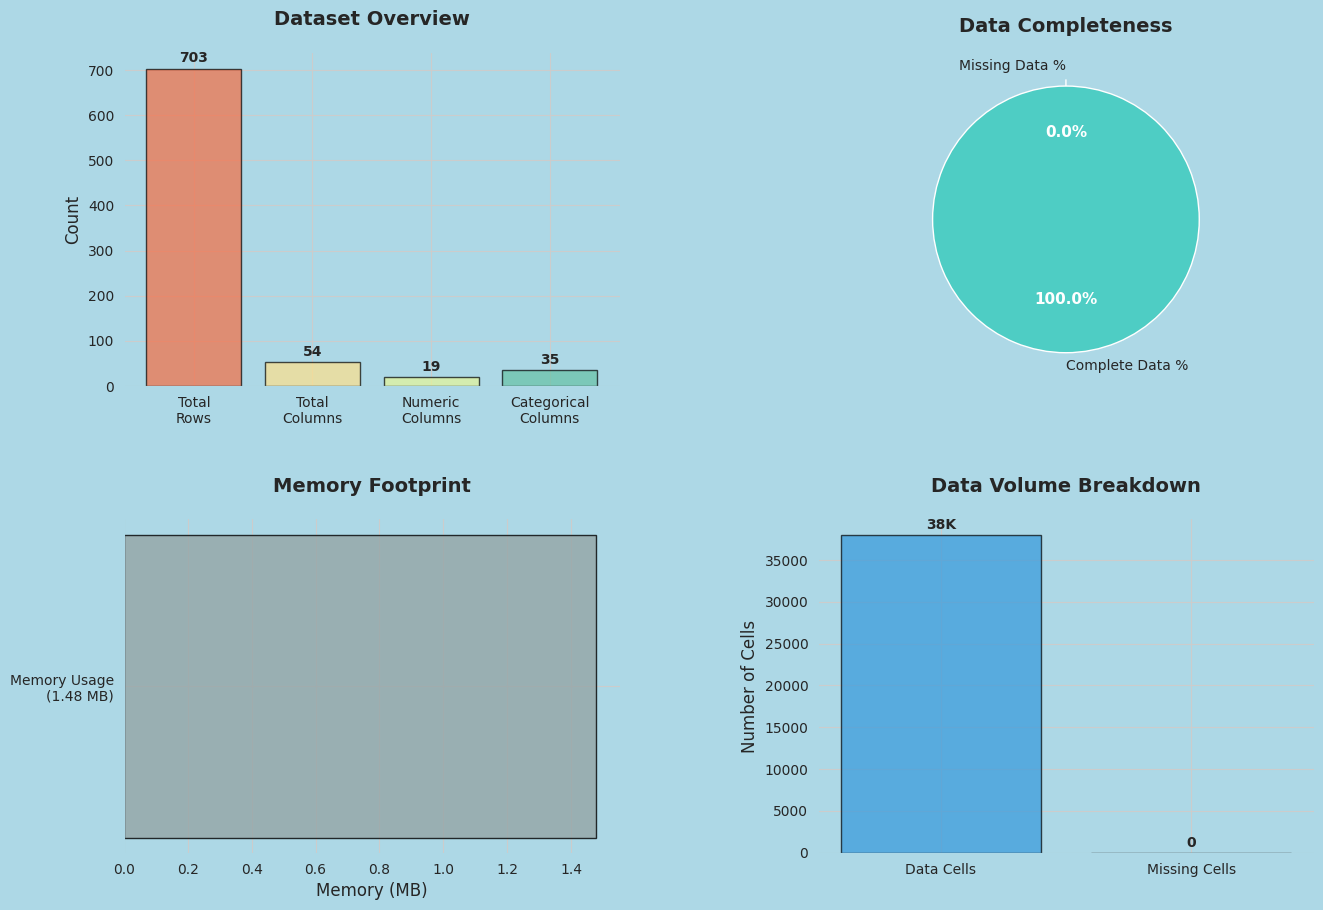

📊 Summary statistics dashboard created and displayed


In [14]:
# Step 5a: Create summary statistics visualization
summary_fig = processor.visualizer.create_summary_stats_visualization(
    analysis_results["summary_stats"]
)
print("📊 Summary statistics dashboard created and displayed")


### Price Distribution Plot

Generate price distribution analysis plot separately.


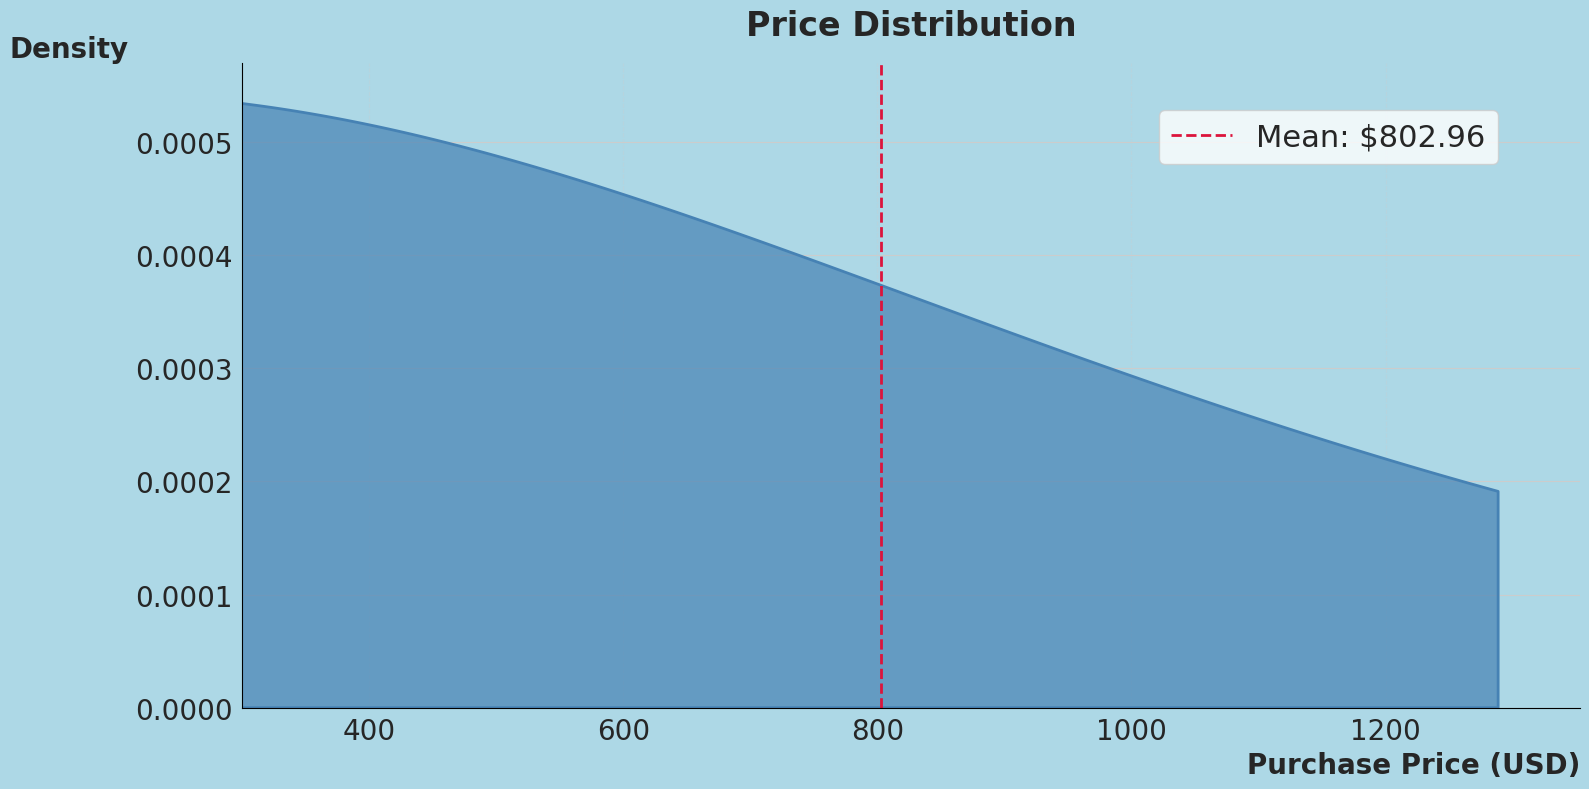

💰 Price distribution analysis plot created and displayed


In [43]:
# Step 5c: Create price distribution plot
price_dist_fig = processor.visualizer.create_price_distribution_plot(
    cleaned_data
)
print("💰 Price distribution analysis plot created and displayed")


### Step 5d: Create Brand Price Comparison Plot

Generate brand price comparison analysis plot separately.


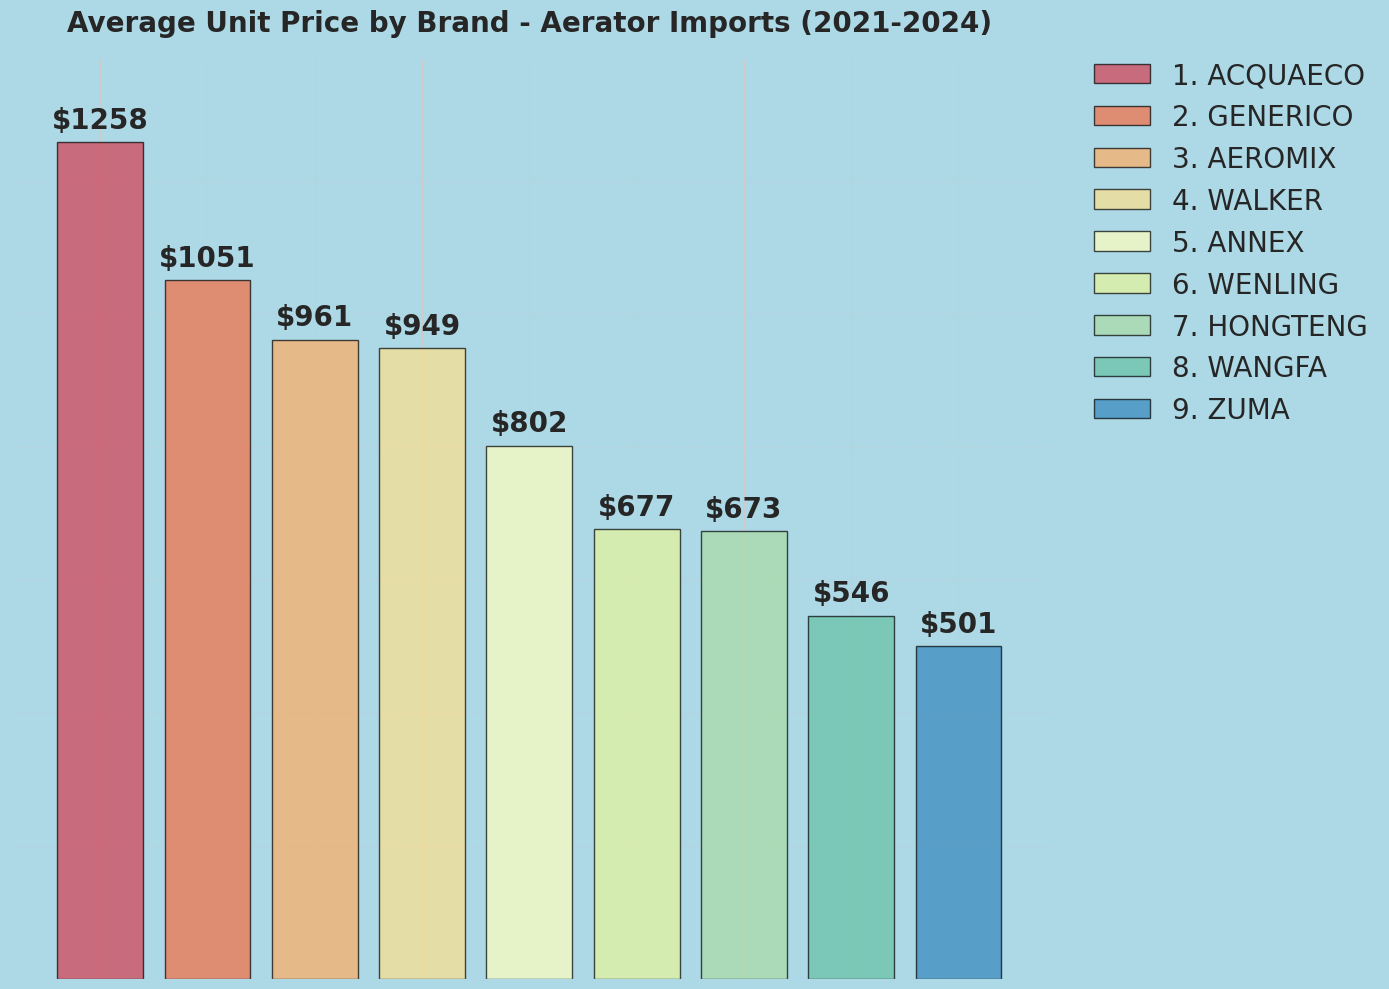

🏷️  Brand price comparison analysis plot created and displayed


In [63]:
# Step 5d: Create brand price comparison plot
brand_price_fig = processor.visualizer.create_brand_price_comparison_plot(
    cleaned_data
)
print("🏷️  Brand price comparison analysis plot created and displayed")


In [65]:
# Memory optimization: Clean up intermediate variables if needed
import gc

gc.collect()  # Force garbage collection to free memory
print("🧹 Memory cleanup completed - ready for additional analysis if needed")


🧹 Memory cleanup completed - ready for additional analysis if needed


## Data Summary Statistics

Let's examine the basic statistics of our processed dataset.


In [66]:
# Display summary statistics
summary_stats = analysis_results["summary_stats"]
print("📊 DATASET SUMMARY STATISTICS:")
print("=" * 50)
for key, value in summary_stats.items():
    if isinstance(value, float):
        print(f"{key.replace('_', ' ').title()}: {value:.2f}")
    else:
        print(f"{key.replace('_', ' ').title()}: {value:,}")


📊 DATASET SUMMARY STATISTICS:
Total Rows: 703
Total Columns: 54
Missing Cells: 0
Missing Percentage: 0.00
Memory Usage Mb: 1.48
Numeric Columns: 19
Categorical Columns: 35


## Missing Values Analysis

Check for missing values in the dataset.


In [67]:
# Display missing values report
missing_values_report = analysis_results["missing_values"]
if not missing_values_report.empty:
    print("⚠️  MISSING VALUES REPORT:")
    print("=" * 50)
    print(missing_values_report.to_string())
else:
    print("✅ No missing values found in the cleaned dataset!")


✅ No missing values found in the cleaned dataset!


## Top Categories Analysis

Analyze the most common brands, models, and countries of origin.


In [68]:
# Display top brands
print("🏷️  TOP BRANDS:")
print("=" * 30)
print(analysis_results["top_brands"].to_string(index=False))

print("\n\n🔧 TOP MODELS:")
print("=" * 30)
print(analysis_results["top_models"].to_string(index=False))

print("\n\n🌍 TOP COUNTRIES:")
print("=" * 30)
print(analysis_results["top_countries"].to_string(index=False))


🏷️  TOP BRANDS:
   Marca  Count  Percentage (%)
GENERICO    412           58.61
 NEOPERL     69            9.82
    DIVA     21            2.99
  WALKER     16            2.28
      FV     14            1.99
AQUARAME     12            1.71
 RENAULT     11            1.56
 BERAQUA     11            1.56
ACQUAECO      8            1.14
    TEKA      8            1.14


🔧 TOP MODELS:
Modelo Mercaderia  Count  Percentage (%)
         GENERICO    352           50.07
           PA-308     19            2.70
      40200103315     11            1.56
      44303403304     10            1.42
      40100102305      8            1.14
             ZUMA      8            1.14
   55650-37060-B0      7            1.00
       96764769ZD      6            0.85
      43220145002      6            0.85
  39080 16HPW-16I      6            0.85


🌍 TOP COUNTRIES:
Pais De Procedencia  Count  Percentage (%)
              CHINA    475           67.57
              ITALY     71           10.10
      UNITED STAT

## Price Distribution Analysis

Examine the price statistics for aerator imports.


In [69]:
# Display price statistics
price_stats = analysis_results["price_stats"]
print("💰 PRICE DISTRIBUTION STATISTICS:")
print("=" * 40)
for key, value in price_stats.items():
    print(f"{key.replace('_', ' ').title()}: ${value:.2f}")


💰 PRICE DISTRIBUTION STATISTICS:
Count: $703.00
Mean: $802.96
Median: $34.30
Std: $4440.37
Min: $0.05
Max: $85250.00
Q25: $3.54
Q75: $563.00
Q95: $1288.63
